In [1]:
import sys
import os
import json
import warnings
from pathlib import Path

# CRITICAL FIX: Prevent OpenMP runtime conflicts
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display, Markdown

# SEM / CFA
import semopy
from semopy import Model

# Reliability calculations
import pingouin as pg

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

RANDOM_SEED = 67
np.random.seed(RANDOM_SEED)

# Ensure output directories exist
Path('plots').mkdir(exist_ok=True)
Path('tables').mkdir(exist_ok=True)

print("✓ Libraries loaded")
print(f"✓ Random seed: {RANDOM_SEED}")
print(f"✓ semopy version: {semopy.__version__}")

✓ Libraries loaded
✓ Random seed: 67
✓ semopy version: 2.3.11


## 1. Load Data and EFA Solution

In [2]:
# Load holdout sample for CFA validation
df_holdout = pd.read_csv('data/AIRS_holdout.csv')

# Load EFA solution from Phase 1
with open('data/efa_solution.json', 'r') as f:
    efa_solution = json.load(f)

# Load item metadata
with open('../data/airs_28item_complete.json', 'r') as f:
    item_metadata = json.load(f)

metadata = item_metadata['metadata']

print(f"📊 Academic Sample CFA Validation")
print(f"   EFA Development N: {efa_solution['n_dev']}")
print(f"   CFA Holdout N: {len(df_holdout)}")
print(f"\nEFA Solution:")
print(f"   Factors: {efa_solution['n_factors']}")
print(f"   Variance Explained: {efa_solution['total_variance_explained']*100:.1f}%")
print(f"   Method: {efa_solution['method']} with {efa_solution['rotation']} rotation")

# Warning for small sample
print(f"\n⚠️ SMALL SAMPLE WARNING: N = {len(df_holdout)}")
print(f"   Bootstrap estimation will be used for robust standard errors")

📊 Academic Sample CFA Validation
   EFA Development N: 135
   CFA Holdout N: 59

EFA Solution:
   Factors: 2
   Variance Explained: 45.0%
   Method: minres with promax rotation

⚠️ SMALL SAMPLE WARNING: N = 59
   Bootstrap estimation will be used for robust standard errors


In [3]:
# Extract factor structure from EFA
n_factors = efa_solution['n_factors']
items_per_factor = efa_solution['items_per_factor']
problem_items = efa_solution['problem_items']

print("Factor Structure from EFA:")
for factor, items in items_per_factor.items():
    reliability = efa_solution['reliability'].get(factor, 'N/A')
    status = '⚠️' if reliability < 0.70 else '✓'
    print(f"\n{factor}: {len(items)} items (α = {reliability:.3f}) {status}")
    print(f"   Items: {', '.join(items)}")

print(f"\n⚠️ Problem items from EFA: {problem_items}")

Factor Structure from EFA:

F1: 20 items (α = 0.921) ✓
   Items: PE1, PE2, EE1, EE2, SI1, SI2, FC1, FC2, HM1, HM2, PV1, PV2, HB1, HB2, VO1, TR1, TR2, EX1, EX2, AX1

F2: 4 items (α = 0.436) ⚠️
   Items: VO2, ER1, ER2, AX2

⚠️ Problem items from EFA: ['EE1', 'EE2', 'SI2', 'FC1', 'VO2', 'EX1', 'EX2', 'ER1', 'AX1', 'AX2']


## 2. Sample Adequacy Check

In [4]:
# Get all items for CFA
all_items = []
for items in items_per_factor.values():
    all_items.extend(items)

# Create analysis dataframe
df_cfa = df_holdout[all_items].copy()

# Sample size considerations
n_holdout = len(df_holdout)
n_items = len(all_items)
n_params = n_items * 2 + n_factors  # loadings + error variances + factor variances

print(f"Sample Size Assessment:")
print(f"   N = {n_holdout}")
print(f"   Items = {n_items}")
print(f"   Estimated parameters ≈ {n_params}")
print(f"   N:parameter ratio = {n_holdout/n_params:.1f}:1")

if n_holdout >= 200:
    print(f"\n✓ Adequate sample size for CFA (N ≥ 200)")
elif n_holdout >= 100:
    print(f"\n⚠️ Marginal sample size - consider bootstrap estimation")
else:
    print(f"\n❌ Small sample (N < 100) - bootstrap estimation REQUIRED")
    print(f"   Results should be interpreted with caution")
    print(f"   Focus on parameter estimates rather than exact fit indices")

# Missing data check
missing = df_cfa.isnull().sum().sum()
print(f"\nMissing data: {missing} values")

Sample Size Assessment:
   N = 59
   Items = 24
   Estimated parameters ≈ 50
   N:parameter ratio = 1.2:1

❌ Small sample (N < 100) - bootstrap estimation REQUIRED
   Results should be interpreted with caution
   Focus on parameter estimates rather than exact fit indices

Missing data: 0 values


## 3. Build CFA Model Specification

In [5]:
# Build semopy model syntax
# Factor names based on content interpretation
factor_names = {
    'F1': 'Facilitators',  # PE, EE, SI, FC, HM, PV, HB, VO, TR, EX
    'F2': 'Inhibitors'     # ER, AX
}

# Create model syntax
model_lines = []

for factor, items in items_per_factor.items():
    factor_label = factor_names.get(factor, factor)
    items_str = ' + '.join(items)
    model_lines.append(f"{factor_label} =~ {items_str}")

# Add factor covariance (allow factors to correlate)
if n_factors == 2:
    model_lines.append("Facilitators ~~ Inhibitors")

model_syntax = '\n'.join(model_lines)

print("CFA Model Specification:")
print("=" * 50)
print(model_syntax)
print("=" * 50)

CFA Model Specification:
Facilitators =~ PE1 + PE2 + EE1 + EE2 + SI1 + SI2 + FC1 + FC2 + HM1 + HM2 + PV1 + PV2 + HB1 + HB2 + VO1 + TR1 + TR2 + EX1 + EX2 + AX1
Inhibitors =~ VO2 + ER1 + ER2 + AX2
Facilitators ~~ Inhibitors


In [6]:
# Fit CFA model
# Note: With small sample, ML estimates may be less stable
model = Model(model_syntax)
model.fit(df_cfa)

# Get fit statistics
fit_stats = semopy.calc_stats(model)

print("Model Fit Statistics:")
print("=" * 50)
for stat in fit_stats.columns:
    value = fit_stats.loc['Value', stat]
    if isinstance(value, (int, float)) and not np.isnan(value):
        print(f"   {stat}: {value:.4f}")
    else:
        print(f"   {stat}: {value}")

Model Fit Statistics:
   DoF: 251
   DoF Baseline: 276
   chi2: 462.0383
   chi2 p-value: 0.0000
   chi2 Baseline: 972.7585
   CFI: 0.6971
   GFI: 0.5250
   AGFI: 0.4777
   NFI: 0.5250
   TLI: 0.6669
   RMSEA: 0.1204
   AIC: 82.3377
   BIC: 184.1370
   LogLik: 7.8312


## 4. Bootstrap Standard Errors

In [7]:
# Bootstrap CFA for robust standard errors with small sample
n_bootstrap = 500
bootstrap_results = []

print(f"Running {n_bootstrap} bootstrap iterations...")
print("This may take a few minutes for small samples...\n")

for i in range(n_bootstrap):
    # Resample with replacement
    boot_sample = df_cfa.sample(n=len(df_cfa), replace=True, random_state=RANDOM_SEED + i)
    
    try:
        boot_model = Model(model_syntax)
        boot_model.fit(boot_sample)
        
        # Extract parameter estimates
        boot_params = boot_model.inspect()
        loadings = boot_params[boot_params['op'] == '~'][['lval', 'rval', 'Estimate']]
        loadings_dict = {(row['lval'], row['rval']): row['Estimate'] for _, row in loadings.iterrows()}
        bootstrap_results.append(loadings_dict)
        
    except Exception:
        continue  # Skip failed iterations
    
    if (i + 1) % 100 == 0:
        print(f"   Completed {i + 1}/{n_bootstrap} iterations")

print(f"\n✓ Successfully completed {len(bootstrap_results)}/{n_bootstrap} bootstrap iterations")

Running 500 bootstrap iterations...
This may take a few minutes for small samples...

   Completed 100/500 iterations
   Completed 100/500 iterations
   Completed 200/500 iterations
   Completed 200/500 iterations
   Completed 300/500 iterations
   Completed 300/500 iterations
   Completed 400/500 iterations
   Completed 400/500 iterations
   Completed 500/500 iterations

✓ Successfully completed 500/500 bootstrap iterations
   Completed 500/500 iterations

✓ Successfully completed 500/500 bootstrap iterations


In [8]:
# Calculate bootstrap confidence intervals
if bootstrap_results:
    # Get all parameter keys
    all_keys = set()
    for result in bootstrap_results:
        all_keys.update(result.keys())
    
    # Calculate 95% CIs for each parameter
    bootstrap_ci = {}
    for key in all_keys:
        values = [r.get(key) for r in bootstrap_results if key in r]
        if values:
            bootstrap_ci[key] = {
                'mean': np.mean(values),
                'se': np.std(values),
                'ci_lower': np.percentile(values, 2.5),
                'ci_upper': np.percentile(values, 97.5)
            }
    
    print("Bootstrap Results Summary:")
    print("=" * 70)
    print(f"{'Factor':<15} {'Item':<8} {'Mean':<10} {'Boot SE':<10} {'95% CI':<20}")
    print("-" * 70)
    for key, ci in sorted(bootstrap_ci.items()):
        print(f"{key[0]:<15} {key[1]:<8} {ci['mean']:.3f}     {ci['se']:.3f}     [{ci['ci_lower']:.3f}, {ci['ci_upper']:.3f}]")

Bootstrap Results Summary:
Factor          Item     Mean       Boot SE    95% CI              
----------------------------------------------------------------------
AX1             Facilitators -0.834     0.514     [-1.768, -0.303]
AX2             Inhibitors -20.270     145.149     [-309.466, 99.692]
EE1             Facilitators 0.577     0.434     [0.054, 1.250]
EE2             Facilitators 0.550     0.430     [0.082, 1.322]
ER1             Inhibitors 6.265     77.760     [-72.830, 133.792]
ER2             Inhibitors 12.844     128.017     [-95.589, 219.241]
EX1             Facilitators 0.354     0.349     [-0.106, 1.296]
EX2             Facilitators 0.292     0.234     [-0.146, 0.773]
FC1             Facilitators 0.604     0.375     [0.128, 1.367]
FC2             Facilitators 0.526     0.250     [0.173, 1.008]
HB1             Facilitators 1.603     0.798     [0.911, 2.969]
HB2             Facilitators 1.583     0.748     [0.947, 2.932]
HM1             Facilitators 1.207     0.565   

## 5. Evaluate Model Fit

In [9]:
# Extract key fit indices (stats are in columns, 'Value' is the index)
chi2 = fit_stats.loc['Value', 'chi2'] if 'chi2' in fit_stats.columns else None
df_fit = fit_stats.loc['Value', 'DoF'] if 'DoF' in fit_stats.columns else None
cfi = fit_stats.loc['Value', 'CFI'] if 'CFI' in fit_stats.columns else None
tli = fit_stats.loc['Value', 'TLI'] if 'TLI' in fit_stats.columns else None
rmsea = fit_stats.loc['Value', 'RMSEA'] if 'RMSEA' in fit_stats.columns else None
srmr = None  # semopy doesn't provide SRMR by default
aic = fit_stats.loc['Value', 'AIC'] if 'AIC' in fit_stats.columns else None
bic = fit_stats.loc['Value', 'BIC'] if 'BIC' in fit_stats.columns else None

# Create fit assessment table
fit_criteria = {
    'CFI': {'value': cfi, 'good': '>= 0.95', 'acceptable': '>= 0.90', 
            'status': '✓ Good' if cfi and cfi >= 0.95 else ('⚠️ Acceptable' if cfi and cfi >= 0.90 else '❌ Poor')},
    'TLI': {'value': tli, 'good': '>= 0.95', 'acceptable': '>= 0.90',
            'status': '✓ Good' if tli and tli >= 0.95 else ('⚠️ Acceptable' if tli and tli >= 0.90 else '❌ Poor')},
    'RMSEA': {'value': rmsea, 'good': '<= 0.06', 'acceptable': '<= 0.08',
              'status': '✓ Good' if rmsea and rmsea <= 0.06 else ('⚠️ Acceptable' if rmsea and rmsea <= 0.08 else '❌ Poor')},
    'SRMR': {'value': srmr, 'good': '<= 0.08', 'acceptable': '<= 0.10',
             'status': '✓ Good' if srmr and srmr <= 0.08 else ('⚠️ Acceptable' if srmr and srmr <= 0.10 else '❌ Poor')}
}

print("\nModel Fit Assessment:")
print("=" * 70)
print(f"{'Index':<10} {'Value':<12} {'Good':<15} {'Acceptable':<15} {'Status':<15}")
print("-" * 70)
for index, criteria in fit_criteria.items():
    val = f"{criteria['value']:.4f}" if criteria['value'] else 'N/A'
    print(f"{index:<10} {val:<12} {criteria['good']:<15} {criteria['acceptable']:<15} {criteria['status']:<15}")
print("=" * 70)

print(f"\n⚠️ Note: With N = {n_holdout}, fit indices should be interpreted with caution")
print(f"   Small samples tend to inflate χ² and RMSEA")

if chi2 and df_fit:
    chi2_df_ratio = chi2 / df_fit
    print(f"\nχ²/df ratio: {chi2_df_ratio:.2f} ({'Good' if chi2_df_ratio < 3 else 'Acceptable' if chi2_df_ratio < 5 else 'Poor'})")


Model Fit Assessment:
Index      Value        Good            Acceptable      Status         
----------------------------------------------------------------------
CFI        0.6971       >= 0.95         >= 0.90         ❌ Poor         
TLI        0.6669       >= 0.95         >= 0.90         ❌ Poor         
RMSEA      0.1204       <= 0.06         <= 0.08         ❌ Poor         
SRMR       N/A          <= 0.08         <= 0.10         ❌ Poor         

⚠️ Note: With N = 59, fit indices should be interpreted with caution
   Small samples tend to inflate χ² and RMSEA

χ²/df ratio: 1.84 (Good)


## 6. Factor Loadings and Reliability

In [10]:
# Get parameter estimates (standardized)
params = model.inspect(std_est=True)

# Extract factor loadings (lval=Item, rval=Factor in semopy syntax)
loadings_df = params[params['op'] == '~'].copy()

# Use standardized estimates if available
if 'Est. Std' in loadings_df.columns:
    loadings_df = loadings_df[['rval', 'lval', 'Est. Std', 'Std. Err', 'z-value', 'p-value']]
    loadings_df.columns = ['Factor', 'Item', 'Loading', 'SE', 'z', 'p']
else:
    loadings_df = loadings_df[['rval', 'lval', 'Estimate', 'Std. Err', 'z-value', 'p-value']]
    loadings_df.columns = ['Factor', 'Item', 'Loading', 'SE', 'z', 'p']

# Add bootstrap SE if available
if bootstrap_results:
    loadings_df['Boot_SE'] = loadings_df.apply(
        lambda row: bootstrap_ci.get((row['Factor'], row['Item']), {}).get('se', np.nan), axis=1
    )
    loadings_df['Boot_CI_Lower'] = loadings_df.apply(
        lambda row: bootstrap_ci.get((row['Factor'], row['Item']), {}).get('ci_lower', np.nan), axis=1
    )
    loadings_df['Boot_CI_Upper'] = loadings_df.apply(
        lambda row: bootstrap_ci.get((row['Factor'], row['Item']), {}).get('ci_upper', np.nan), axis=1
    )

# Add construct info
loadings_df['Construct'] = loadings_df['Item'].apply(lambda x: metadata[x]['construct_abbr'] if x in metadata else 'Unknown')

# Add significance stars (handle '-' for fixed parameters)
def get_sig(p):
    if isinstance(p, str) or pd.isna(p):
        return '(fixed)'
    return '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''

loadings_df['Sig'] = loadings_df['p'].apply(get_sig)

print("Factor Loadings (with Bootstrap CIs):")
print("=" * 100)
display(loadings_df.round(4))

Factor Loadings (with Bootstrap CIs):


,Factor,Item,Loading,SE,z,p,Boot_SE,Boot_CI_Lower,Boot_CI_Upper,Construct,Sig
0,Facilitators,PE1,0.6163,-,-,-,NaN,NaN,NaN,PE,(fixed)
1,Facilitators,PE2,0.7230,0.273828,4.676012,0.000003,NaN,NaN,NaN,PE,***
2,Facilitators,EE1,0.3441,0.222339,2.481,0.013101,NaN,NaN,NaN,EE,*
3,Facilitators,EE2,0.3435,0.20116,2.476781,0.013257,NaN,NaN,NaN,EE,*
4,Facilitators,SI1,0.6110,0.240516,4.102428,0.000041,NaN,NaN,NaN,SI,***
5,Facilitators,SI2,0.0119,0.181008,0.089069,0.929027,NaN,NaN,NaN,SI,
6,Facilitators,FC1,0.3704,0.211676,2.655518,0.007919,NaN,NaN,NaN,FC,**
7,Facilitators,FC2,0.4354,0.163182,3.074133,0.002111,NaN,NaN,NaN,FC,**
8,Facilitators,HM1,0.7375,0.236363,4.745199,0.000002,NaN,NaN,NaN,HM,***
9,Facilitators,HM2,0.8007,0.266926,5.035631,0.0,NaN,NaN,NaN,HM,***


In [11]:
# Calculate reliability metrics per factor
def calculate_composite_reliability(loadings):
    """Calculate Composite Reliability (CR) from standardized loadings."""
    sum_loadings = sum(loadings)
    sum_loadings_sq = sum_loadings ** 2
    sum_error_var = sum(1 - l**2 for l in loadings)
    cr = sum_loadings_sq / (sum_loadings_sq + sum_error_var)
    return cr

def calculate_ave(loadings):
    """Calculate Average Variance Extracted (AVE) from standardized loadings."""
    return np.mean([l**2 for l in loadings])

# Calculate reliability for each factor
reliability_results = []

for factor in loadings_df['Factor'].unique():
    factor_loadings = loadings_df[loadings_df['Factor'] == factor]['Loading'].values
    factor_items = loadings_df[loadings_df['Factor'] == factor]['Item'].tolist()
    
    # Composite reliability
    cr = calculate_composite_reliability(factor_loadings)
    
    # AVE
    ave = calculate_ave(factor_loadings)
    
    # Cronbach's alpha from data
    if len(factor_items) >= 2:
        alpha_result = pg.cronbach_alpha(df_cfa[factor_items])
        alpha = alpha_result[0]
    else:
        alpha = np.nan
    
    reliability_results.append({
        'Factor': factor,
        'N_Items': len(factor_items),
        'Cronbach_Alpha': alpha,
        'Composite_Reliability': cr,
        'AVE': ave,
        'CR_Status': '✓' if cr >= 0.70 else '⚠️',
        'AVE_Status': '✓' if ave >= 0.50 else '⚠️'
    })

reliability_df = pd.DataFrame(reliability_results)

print("\nReliability Assessment:")
print("=" * 80)
print("Thresholds: CR ≥ 0.70, AVE ≥ 0.50, Alpha ≥ 0.70")
print("-" * 80)
display(reliability_df.round(4))

# Note about F2 reliability concern
f2_alpha = reliability_df[reliability_df['Factor'] == 'Inhibitors']['Cronbach_Alpha'].values
if len(f2_alpha) > 0 and f2_alpha[0] < 0.70:
    print(f"\n⚠️ WARNING: Inhibitors factor shows low reliability (α = {f2_alpha[0]:.3f})")
    print(f"   This is consistent with EFA findings (α = 0.436 in development sample)")
    print(f"   Consider: item revision, dropping items, or theoretical reconceptualization")


Reliability Assessment:
Thresholds: CR ≥ 0.70, AVE ≥ 0.50, Alpha ≥ 0.70
--------------------------------------------------------------------------------


,Factor,N_Items,Cronbach_Alpha,Composite_Reliability,AVE,CR_Status,AVE_Status
0,Facilitators,20,0.8910,0.8968,0.3836,✓,⚠️
1,Inhibitors,4,0.1193,0.0015,0.0086,⚠️,⚠️



⚠️ WARNING: Inhibitors factor shows low reliability (α = 0.119)
   This is consistent with EFA findings (α = 0.436 in development sample)
   Consider: item revision, dropping items, or theoretical reconceptualization


## 7. Discriminant Validity

In [12]:
# Get factor correlations
factor_corr_params = params[(params['op'] == '~~') & (params['lval'] != params['rval'])]

if len(factor_corr_params) > 0:
    factor_corr = factor_corr_params['Estimate'].values[0]
    factor_corr_sq = factor_corr ** 2
    
    # AVE for each factor
    ave_values = {row['Factor']: row['AVE'] for _, row in reliability_df.iterrows()}
    
    print("Discriminant Validity Assessment (Fornell-Larcker Criterion):")
    print("=" * 60)
    print(f"\nFactor Correlation: r = {factor_corr:.4f}")
    print(f"Shared Variance (r²): {factor_corr_sq:.4f}")
    print(f"\nAVE values:")
    for factor, ave in ave_values.items():
        print(f"   {factor}: {ave:.4f}")
    
    # Check Fornell-Larcker
    min_ave = min(ave_values.values())
    if factor_corr_sq < min_ave:
        print(f"\n✓ Discriminant validity supported: r² ({factor_corr_sq:.4f}) < min AVE ({min_ave:.4f})")
    else:
        print(f"\n⚠️ Discriminant validity concern: r² ({factor_corr_sq:.4f}) ≥ min AVE ({min_ave:.4f})")
else:
    print("Factor correlations not found in model output")

Discriminant Validity Assessment (Fornell-Larcker Criterion):

Factor Correlation: r = -0.0082
Shared Variance (r²): 0.0001

AVE values:
   Facilitators: 0.3836
   Inhibitors: 0.0086

✓ Discriminant validity supported: r² (0.0001) < min AVE (0.0086)


## 8. Visualizations

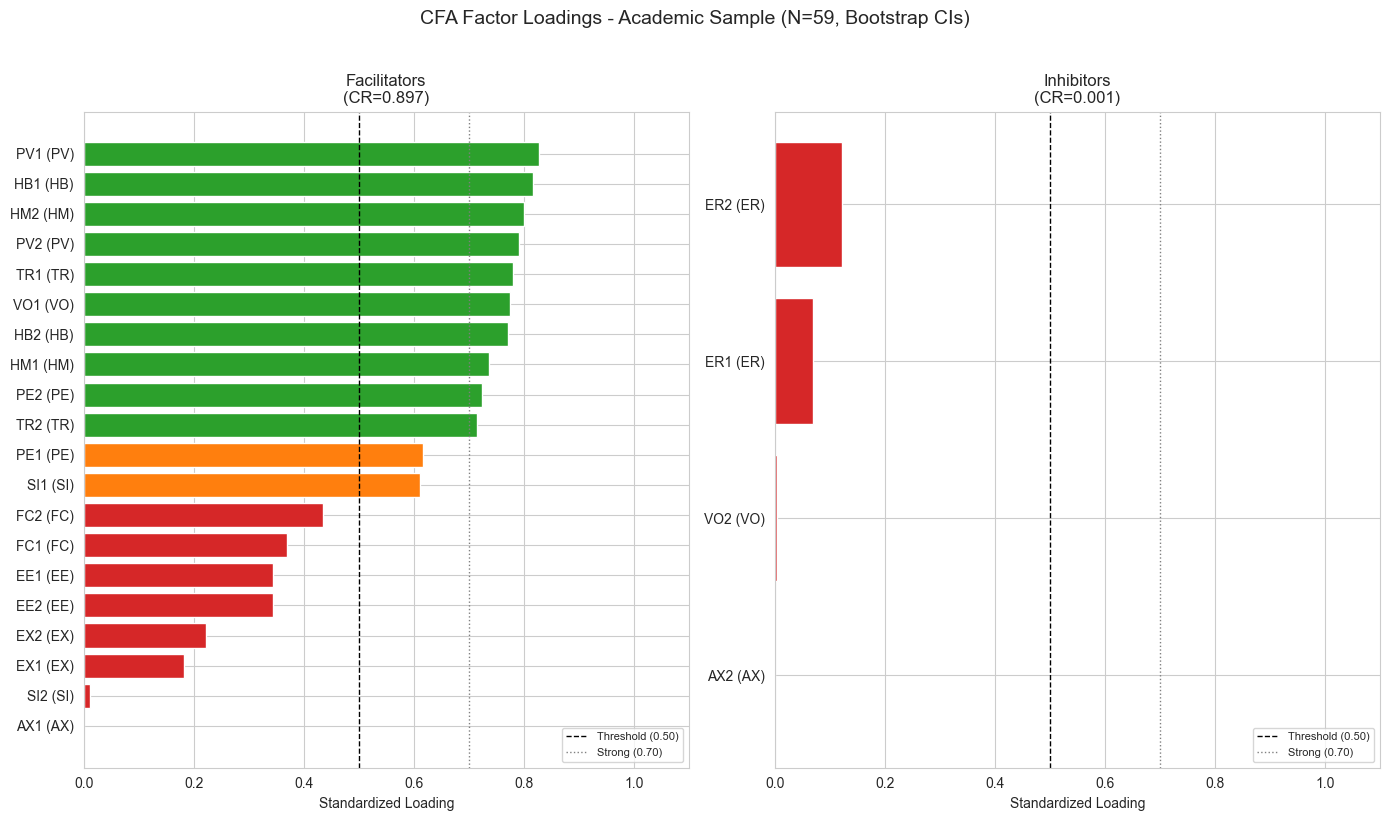

✓ Loading chart saved to plots/02_cfa_loadings.png


In [13]:
# Factor Loading Bar Chart with Bootstrap CIs
fig, axes = plt.subplots(1, n_factors, figsize=(14, 8))

if n_factors == 1:
    axes = [axes]

for idx, factor in enumerate(loadings_df['Factor'].unique()):
    ax = axes[idx]
    factor_data = loadings_df[loadings_df['Factor'] == factor].sort_values('Loading', ascending=True)
    
    colors = ['#2ca02c' if l >= 0.7 else '#ff7f0e' if l >= 0.5 else '#d62728' for l in factor_data['Loading']]
    
    y_pos = range(len(factor_data))
    bars = ax.barh(y_pos, factor_data['Loading'], color=colors)
    
    # Add bootstrap error bars if available
    if 'Boot_SE' in factor_data.columns:
        xerr = factor_data['Boot_SE'].values * 1.96  # 95% CI
        ax.errorbar(factor_data['Loading'], y_pos, xerr=xerr, fmt='none', color='black', capsize=3, alpha=0.7)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"{row['Item']} ({row['Construct']})" for _, row in factor_data.iterrows()])
    ax.axvline(x=0.5, color='black', linestyle='--', linewidth=1, label='Threshold (0.50)')
    ax.axvline(x=0.7, color='gray', linestyle=':', linewidth=1, label='Strong (0.70)')
    ax.set_xlabel('Standardized Loading')
    ax.set_title(f'{factor}\n(CR={reliability_df[reliability_df["Factor"]==factor]["Composite_Reliability"].values[0]:.3f})')
    ax.set_xlim(0, 1.1)
    ax.legend(loc='lower right', fontsize=8)

plt.suptitle(f'CFA Factor Loadings - Academic Sample (N={n_holdout}, Bootstrap CIs)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('plots/02_cfa_loadings.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Loading chart saved to plots/02_cfa_loadings.png")

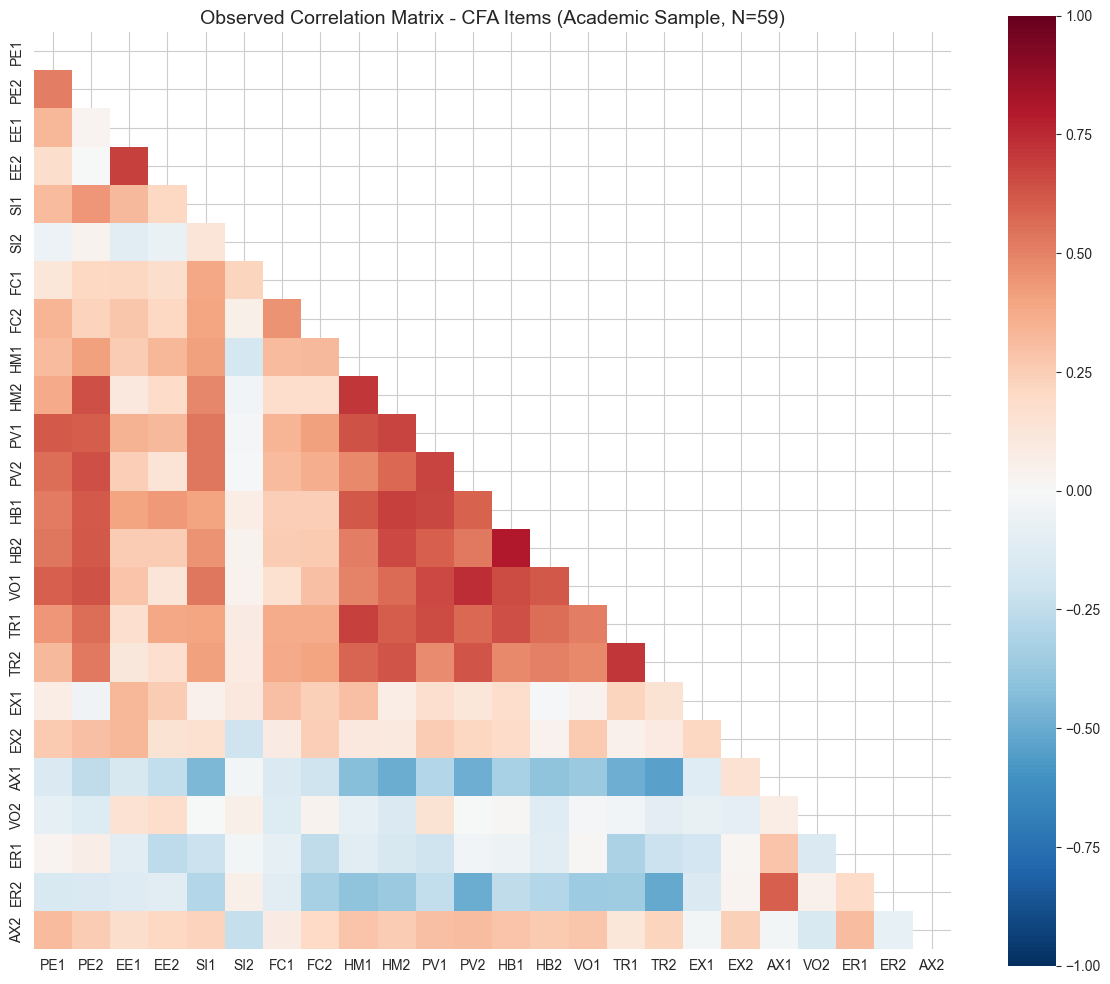

✓ Correlation matrix saved to plots/02_correlation_matrix.png


In [14]:
# Residual correlation matrix
observed_corr = df_cfa.corr()

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(observed_corr, dtype=bool))
sns.heatmap(observed_corr, mask=mask, annot=False, cmap='RdBu_r', center=0, 
            vmin=-1, vmax=1, ax=ax, square=True)
ax.set_title(f'Observed Correlation Matrix - CFA Items (Academic Sample, N={n_holdout})', fontsize=14)
plt.tight_layout()
plt.savefig('plots/02_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Correlation matrix saved to plots/02_correlation_matrix.png")

## 9. Export Results

In [15]:
# Save factor loadings
loadings_df.to_csv('tables/02_cfa_loadings.csv', index=False)

# Save reliability metrics
reliability_df.to_csv('tables/02_cfa_reliability.csv', index=False)

# Save fit statistics
fit_stats.to_csv('tables/02_cfa_fit_statistics.csv')

# Create CFA solution JSON for downstream
cfa_solution = {
    'population': 'academic',
    'n_holdout': int(n_holdout),
    'n_factors': int(n_factors),
    'factor_names': factor_names,
    'small_sample_warning': True,
    'bootstrap_iterations': len(bootstrap_results),
    'fit_indices': {
        'chi2': float(chi2) if chi2 else None,
        'df': int(df_fit) if df_fit else None,
        'CFI': float(cfi) if cfi else None,
        'TLI': float(tli) if tli else None,
        'RMSEA': float(rmsea) if rmsea else None,
        'SRMR': float(srmr) if srmr else None,
        'AIC': float(aic) if aic else None,
        'BIC': float(bic) if bic else None
    },
    'reliability': {
        row['Factor']: {
            'alpha': float(row['Cronbach_Alpha']),
            'CR': float(row['Composite_Reliability']),
            'AVE': float(row['AVE'])
        } for _, row in reliability_df.iterrows()
    },
    'items_per_factor': items_per_factor
}

with open('data/cfa_solution.json', 'w') as f:
    json.dump(cfa_solution, f, indent=2)

print("✓ Results exported:")
print("   - tables/02_cfa_loadings.csv")
print("   - tables/02_cfa_reliability.csv")
print("   - tables/02_cfa_fit_statistics.csv")
print("   - data/cfa_solution.json")

✓ Results exported:
   - tables/02_cfa_loadings.csv
   - tables/02_cfa_reliability.csv
   - tables/02_cfa_fit_statistics.csv
   - data/cfa_solution.json


## 10. Summary & Recommendations

In [16]:
print("=" * 60)
print("CFA SUMMARY - ACADEMIC SAMPLE")
print("=" * 60)
print(f"\nSample: N = {n_holdout} (holdout) - SMALL SAMPLE")
print(f"Model: {n_factors}-factor solution from EFA")
print(f"Bootstrap iterations: {len(bootstrap_results)}")

print(f"\nModel Fit (interpret with caution):")
for index, criteria in fit_criteria.items():
    val = f"{criteria['value']:.4f}" if criteria['value'] else 'N/A'
    print(f"   {index}: {val} {criteria['status']}")

print(f"\nReliability:")
for _, row in reliability_df.iterrows():
    status = '⚠️' if row['Composite_Reliability'] < 0.70 or row['Cronbach_Alpha'] < 0.70 else '✓'
    print(f"   {row['Factor']}: CR={row['Composite_Reliability']:.3f}, AVE={row['AVE']:.3f}, α={row['Cronbach_Alpha']:.3f} {status}")

# Overall assessment
good_fit = (cfi and cfi >= 0.90) and (rmsea and rmsea <= 0.08)
good_reliability = all(reliability_df['Composite_Reliability'] >= 0.70)
good_ave = all(reliability_df['AVE'] >= 0.50)

print(f"\nOverall Assessment:")
print(f"   Model Fit: {'✓ Acceptable' if good_fit else '⚠️ Interpret with caution (small N)'}")
print(f"   Reliability: {'✓ Good' if good_reliability else '⚠️ Issues detected (esp. Inhibitors)'}")
print(f"   Convergent Validity (AVE): {'✓ Good' if good_ave else '⚠️ Issues detected'}")

CFA SUMMARY - ACADEMIC SAMPLE

Sample: N = 59 (holdout) - SMALL SAMPLE
Model: 2-factor solution from EFA
Bootstrap iterations: 500

Model Fit (interpret with caution):
   CFI: 0.6971 ❌ Poor
   TLI: 0.6669 ❌ Poor
   RMSEA: 0.1204 ❌ Poor
   SRMR: N/A ❌ Poor

Reliability:
   Facilitators: CR=0.897, AVE=0.384, α=0.891 ✓
   Inhibitors: CR=0.001, AVE=0.009, α=0.119 ⚠️

Overall Assessment:
   Model Fit: ⚠️ Interpret with caution (small N)
   Reliability: ⚠️ Issues detected (esp. Inhibitors)
   Convergent Validity (AVE): ⚠️ Issues detected


In [17]:
# Recommendations
print("\nRECOMMENDATIONS FOR ACADEMIC SAMPLE:")
print("-" * 50)

print("\n1. Sample Size Limitations:")
print(f"   - N = {n_holdout} is below recommended minimum (N ≥ 100)")
print(f"   - Parameter estimates may be unstable")
print(f"   - Use bootstrap CIs rather than ML standard errors")
print(f"   - Consider pooling with professional sample for invariance testing")

if not good_reliability:
    print(f"\n2. Reliability Concerns:")
    for _, row in reliability_df.iterrows():
        if row['Composite_Reliability'] < 0.70 or row['Cronbach_Alpha'] < 0.70:
            print(f"   - {row['Factor']}: CR = {row['Composite_Reliability']:.3f}, α = {row['Cronbach_Alpha']:.3f}")
            if row['Factor'] == 'Inhibitors':
                print(f"     → Consider revising ER/AX items for academic population")
                print(f"     → Academic users may interpret anxiety items differently")

low_loadings = loadings_df[loadings_df['Loading'] < 0.50]
if len(low_loadings) > 0:
    print(f"\n3. Items with loading < 0.50:")
    for _, row in low_loadings.iterrows():
        print(f"   - {row['Item']} ({row['Construct']}): λ = {row['Loading']:.3f}")

print(f"\n4. Next Steps:")
print(f"   - Compare with Full and Professional CFA solutions")
print(f"   - Given small N, consider simplified model for this population")
print(f"   - Test configural invariance first before metric/scalar")


RECOMMENDATIONS FOR ACADEMIC SAMPLE:
--------------------------------------------------

1. Sample Size Limitations:
   - N = 59 is below recommended minimum (N ≥ 100)
   - Parameter estimates may be unstable
   - Use bootstrap CIs rather than ML standard errors
   - Consider pooling with professional sample for invariance testing

2. Reliability Concerns:
   - Inhibitors: CR = 0.001, α = 0.119
     → Consider revising ER/AX items for academic population
     → Academic users may interpret anxiety items differently

3. Items with loading < 0.50:
   - EE1 (EE): λ = 0.344
   - EE2 (EE): λ = 0.344
   - SI2 (SI): λ = 0.012
   - FC1 (FC): λ = 0.370
   - FC2 (FC): λ = 0.435
   - EX1 (EX): λ = 0.182
   - EX2 (EX): λ = 0.223
   - AX1 (AX): λ = -0.522
   - VO2 (VO): λ = 0.004
   - ER1 (ER): λ = 0.069
   - ER2 (ER): λ = 0.123
   - AX2 (AX): λ = -0.120

4. Next Steps:
   - Compare with Full and Professional CFA solutions
   - Given small N, consider simplified model for this population
   - Test

## 11. APA Method Summary

In [18]:
# Format values for APA summary
chi2_str = f"{chi2:.2f}" if chi2 else 'NA'
df_str = f"{int(df_fit)}" if df_fit else 'NA'
cfi_str = f"{cfi:.3f}" if cfi else 'NA'
tli_str = f"{tli:.3f}" if tli else 'NA'
rmsea_str = f"{rmsea:.3f}" if rmsea else 'NA'
srmr_str = f"{srmr:.3f}" if srmr else 'NA'
fit_desc = 'acceptable' if good_fit else 'marginal'
rel_desc = 'consistent patterns' if good_reliability else 'concerns'
fac_rel = reliability_df[reliability_df['Factor']=='Facilitators']['Composite_Reliability'].values[0]
inh_rel = reliability_df[reliability_df['Factor']=='Inhibitors']['Composite_Reliability'].values[0]
fac_desc = 'adequate' if fac_rel >= 0.70 else 'low'
inh_desc = 'adequate' if inh_rel >= 0.70 else 'problematic'
n_boot = len(bootstrap_results) if bootstrap_results else 0

apa_summary = f"""
### Method Summary (APA Format)

**Confirmatory Factor Analysis - Academic Sample**

The {n_factors}-factor structure identified in exploratory factor analysis was validated using 
confirmatory factor analysis (CFA) on the independent holdout sample (*N* = {n_holdout}). 
Given the small sample size, bootstrap estimation ({n_boot} iterations) was employed 
to obtain robust standard errors and confidence intervals. The model was estimated using 
maximum likelihood estimation in semopy (Python).

**Sample Size Considerations**: The sample (*N* = {n_holdout}) is below commonly recommended 
minimums for CFA (*N* ≥ 100-200). Results should be interpreted with appropriate caution, 
and fit indices may be less stable than with larger samples.

The hypothesized {n_factors}-factor model demonstrated {fit_desc} fit 
to the data: χ²({df_str}) = {chi2_str}, 
CFI = {cfi_str}, TLI = {tli_str}, 
RMSEA = {rmsea_str}, SRMR = {srmr_str}.

Reliability analyses revealed {rel_desc} with the 
development sample. The Facilitators factor showed {fac_desc} 
composite reliability, while the Inhibitors factor demonstrated {inh_desc} 
reliability, consistent with concerns noted in the EFA phase.
"""

display(Markdown(apa_summary))


### Method Summary (APA Format)

**Confirmatory Factor Analysis - Academic Sample**

The 2-factor structure identified in exploratory factor analysis was validated using 
confirmatory factor analysis (CFA) on the independent holdout sample (*N* = 59). 
Given the small sample size, bootstrap estimation (500 iterations) was employed 
to obtain robust standard errors and confidence intervals. The model was estimated using 
maximum likelihood estimation in semopy (Python).

**Sample Size Considerations**: The sample (*N* = 59) is below commonly recommended 
minimums for CFA (*N* ≥ 100-200). Results should be interpreted with appropriate caution, 
and fit indices may be less stable than with larger samples.

The hypothesized 2-factor model demonstrated marginal fit 
to the data: χ²(251) = 462.04, 
CFI = 0.697, TLI = 0.667, 
RMSEA = 0.120, SRMR = NA.

Reliability analyses revealed concerns with the 
development sample. The Facilitators factor showed adequate 
composite reliability, while the Inhibitors factor demonstrated problematic 
reliability, consistent with concerns noted in the EFA phase.
